In [114]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot

from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [115]:
##Dates
#From general trajectory, we can arrive conservatively between june 17th 2037 & 6th august
arrival_date_first=time.Time("2037-06-17 00:01", scale="utc").tdb
arrival_date_second=time.Time("2037-06-21 00:01", scale="utc").tdb  
arrival_dates=time_range(arrival_date_first, end=arrival_date_second, periods=50)
sim_end_date = time.Time("2037-09-01 00:01", scale="utc").tdb

simulation_epoch=time_range(start=arrival_date_first,end=sim_end_date,periods=50)


io_ephem = Ephem.from_horizons(501,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Io is 501
ganymede_ephem = Ephem.from_horizons(503,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Ganymede is 503
europa_ephem = Ephem.from_horizons(502,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Europa is 502
callisto_ephem = Ephem.from_horizons(504,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC) 


##Orbital Insertion Parameters
c3 = 550*u.km**2/u.s**2  
r_perijove = Jupiter.R+200000 * u.km
r_apijove = Jupiter.R+2e7*u.km

placeholder_ganymede_orbit=Orbit.from_ephem(Jupiter,ganymede_ephem,arrival_date_first)
placeholder_callisto_orbit=Orbit.from_ephem(Jupiter,callisto_ephem,arrival_date_first)
placeholder_europa_orbit=Orbit.from_ephem(Jupiter,europa_ephem,arrival_date_first)

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"



In [116]:
# arrival_date=arrival_date_first
# plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

lowest_dv=1000*u.m/u.s
character=[]


#arrival date is date of insertion into jupiter orbit
for arrival_date in arrival_dates:   
    a_exit = (r_perijove+r_apijove)/2
    ecc_exit = (r_perijove-r_apijove)/(r_perijove+r_apijove)


    arrival_orbit = Orbit.from_classical(
        Jupiter,
        a_exit,
        ecc_exit,
        placeholder_ganymede_orbit.inc,
        placeholder_ganymede_orbit.raan,
        0 * u.deg,
        180 * u.deg,  
        time.Time(arrival_date, scale="utc"),
        plane=Planes.EARTH_ECLIPTIC
    )
    for tof in range(55,65)*u.day:
        ganymede_orb= placeholder_ganymede_orbit.propagate(arrival_date+tof)
        lambert=Maneuver.lambert(arrival_orbit,ganymede_orb,M=0)
        dv=np.linalg.norm(lambert[0][1])
        if dv<lowest_dv:
            lowest_dv=dv
            character=[arrival_date,tof,arrival_orbit,lambert]
print(lowest_dv)
print(character)
arrival_date_final=character[0]
tof_final=character[1]



/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/astropy/units/decorators.py:302: UserWarning:

Wrapping true anomaly to -π <= nu < π



306.7752419551946 m / s
[<Time object: scale='tdb' format='iso' value=2037-06-20 20:07:03.062>, <Quantity 62. d>, 0 x 0 AU x 2.3 deg orbit around Jupiter (♃) at epoch 2037-06-20 20:05:53.878 (UTC), Number of impulses: 2, Total cost: 13.030271 km / s]


Entered into 271483 x 8831671 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-06-20 20:05:53.878 (UTC)
with perijove 199990.99951240415 km


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"



Period of insertion orbit: 62.733389544564076 d


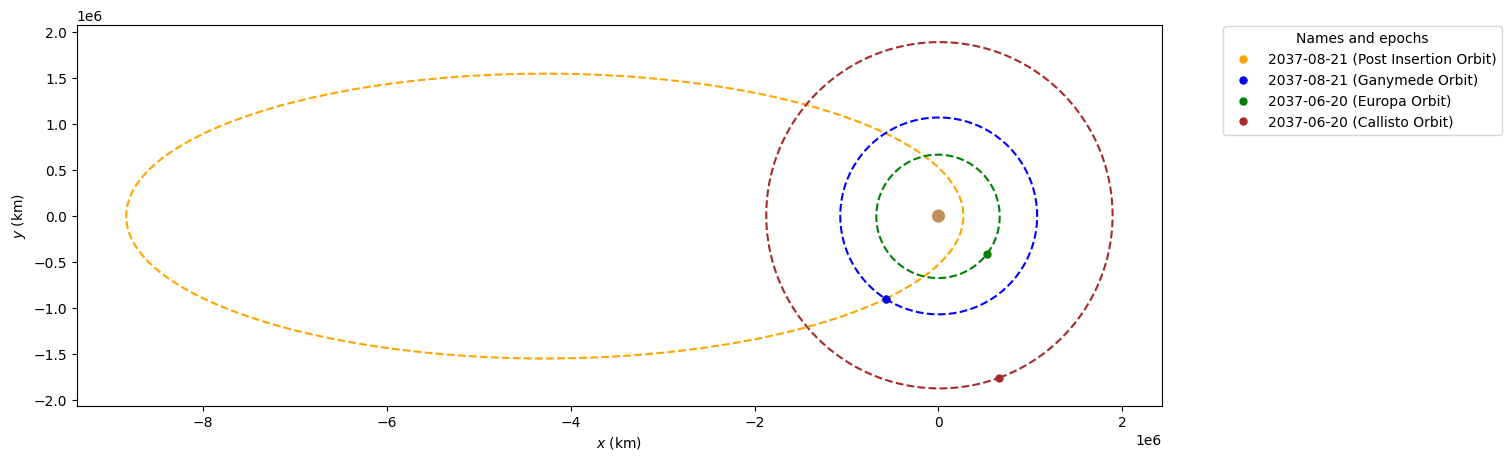

In [117]:
first_assist_date=arrival_date_final+tof_final

ganymede_orb=placeholder_ganymede_orbit.propagate(first_assist_date)
europa_orb=placeholder_europa_orbit.propagate(arrival_date_final)
callisto_orb=placeholder_callisto_orbit.propagate(arrival_date_final)

plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
post_insertion_orb,dummy=character[2].apply_maneuver(character[3],intermediate=True)
print(f"Entered into {post_insertion_orb}")
print(f"with perijove {post_insertion_orb.r_p.to(u.km)-Jupiter.R.to(u.km)}")

post_insertion_orb=post_insertion_orb.propagate(first_assist_date)

plotter.plot(post_insertion_orb, label="Post Insertion Orbit", color="orange")
plotter.plot(ganymede_orb, label="Ganymede Orbit", color="blue")    
# plotter.plot(dummy, label="Transfer Maneuver", color="red")
plotter.plot(europa_orb, label="Europa Orbit", color="green")
plotter.plot(callisto_orb, label="Callisto Orbit", color="brown")
print(f"Period of insertion orbit: {post_insertion_orb.period.to(u.day)}")


Ok, so from general trajectory, we have an arrival at Ganymede on 17th August 2037 from an insertion on 17th June with ~(0.5+0.13)km/s DV. 




-find direction that slows you down relative to Jupiter
-look for orbits that are rational multiple of orbit of the moon

In [118]:
# ##find lowest possible period orbit that is still a multiple of ganymede's period, this can continue until period approaches Ganymedes
# def search_for_resonant_slingshot(body_orb, body, r_p_min, r_p_max):#take in orbit of body we are slingshotting around
#     slingshot_epoch=body_orb.epoch
#     r_ps=np.geomspace(r_p_min,r_p_max)*u.km+body.R
#     for r_p in r_ps:
#         axis = np.array([0,0,1.0])   #rotate in ecliptic plane intitially   
#         rot_ang=2*np.arcsin(1/)



In [119]:
##find lowest possible period orbit that is still a multiple of ganymede's period, this can continue until period approaches Ganymedes
def search_for_resonant_slingshot(body_orb, body, inc_orb_vel, r_p_min, r_p_max, num_samples=150, max_resonance_ratio=10):
    """
    Find the gravity assist that produces the lowest period orbit that is still a resonant multiple of the body's period.
    
    Parameters:
    body_orb: Orbit of the body we're slingshotting around
    body: The body itself (e.g., Ganymede)
    inc_orb_vel: Incoming velocity vector of spacecraft relative to Jupiter
    r_p_min, r_p_max: Min/max periapsis distances for flyby
    num_samples: Number of periapsis values to scan
    max_resonance_ratio: Maximum numerator or denominator to check (default 10)
    
    Returns:
    best_orbit: The resonant orbit with lowest period
    best_resonance: Tuple (n_sc, n_body) representing the resonance ratio
    best_rp: Periapsis distance that achieves this
    """
    
    slingshot_epoch = body_orb.epoch
    body_period = body_orb.period
    
    # Relative velocity & speed to body we are slingshotting around
    rel_vel = inc_orb_vel - body_orb.rv()[1]
    rel_speed = np.linalg.norm(rel_vel)
    
    # Sample periapsis distances
    r_ps = body.R + np.linspace(r_p_min.value, r_p_max.value, num=num_samples) * u.km
    
    # Calculate deflection angles for each periapsis
    rot_angs = 2 * np.arcsin(1 / ((r_ps * rel_speed**2 / body.k) + 1 * u.one))
    
    # Rotation axis in ecliptic plane
    axis = np.array([0, 0, 1.0])
    axis = axis / np.linalg.norm(axis)
    
    best_orbit = None
    best_resonance = None
    best_rp = None
    best_period = np.inf * u.day
    
    # Try both rotation directions (leading/trailing side flybys)
    for sign in [1]:
        for i, rot_ang in enumerate(rot_angs):
            # Rotate the relative velocity
            rot = scipyRot.from_rotvec(sign * axis * rot_ang.value)
            rel_vel_out = rot.apply(rel_vel.value) * u.km / u.s
            
            # Calculate post-assist velocity in Jupiter frame
            post_assist_vel = rel_vel_out + body_orb.rv()[1]
            
            # Create orbit from post-assist state
            test_orb = Orbit.from_vectors(
                Jupiter, 
                body_orb.r, 
                post_assist_vel, 
                slingshot_epoch,
                plane=Planes.EARTH_ECLIPTIC
            )
            
            #only consider orbits that don't crash into the planet
            if test_orb.r_p < Jupiter.R:
                continue
            
            # Only consider bound orbits
            if test_orb.ecc >= 1:
                continue
            
            # Check if orbit crosses body's orbital radius (necessary for resonance)
            body_radius = body_orb.a
            orbit_crosses = (test_orb.r_p < body_radius < test_orb.r_a)
            
            if not orbit_crosses:
                continue
            
            # Calculate the period ratio
            period_ratio = test_orb.period / body_period
            # print(period_ratio)
            # Check for integer resonances by testing simple fractions
            found_resonance = False
            for n_body in range(1, max_resonance_ratio + 1):
                for n_sc in range(1, max_resonance_ratio + 1):
                    expected_ratio = n_body / n_sc
                    ratio_error = abs(period_ratio.value - expected_ratio) / expected_ratio
                    
                    if ratio_error < 0.03 :
                        # Check if this is better than current best (lower period)
                        if test_orb.period < best_period:
                            best_period = test_orb.period
                            best_orbit = test_orb
                            best_resonance = (n_sc, n_body)
                            best_rp = r_ps[i]
                            print(f"Found {n_sc}:{n_body} resonance: period={test_orb.period.to(u.day):.2f}, r_p={r_ps[i]:.0f}")
                            found_resonance = True
                            break
                if found_resonance:
                    break
        
        if best_orbit is None:
            print("No resonant orbit found!")
            return None, None, None
        
        print(f"\nBest resonance: {best_resonance[0]}:{best_resonance[1]}")
        print(f"Period: {best_period.to(u.day):.2f} (target body: {body_period.to(u.day):.2f})")
        print(f"Periapsis: {best_rp:.0f}")
        
        return best_orbit, best_resonance, best_rp
    

FIRST GANYMEDE ENCOUNTER
Found 1:5 resonance: period=36.61 d, r_p=2644100 m

Best resonance: 1:5
Period: 36.61 d (target body: 7.15 d)
Periapsis: 2644100 m

=== First Encounter Results ===
Resonance found: 1:5
Spacecraft does 1 orbits while Ganymede does 5
Post-assist orbit period: 36.61 d, it should be close to 35.76 d
Ganymede period: 7.15 d
Flyby periapsis altitude: 10 km
Eccentricity: 0.926
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694771e-04 6.52945451e-05 1.84869215e-05] km / s
[9.97694

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"




=== Mission Summary ===
Total ΔV for resonance corrections: 51.00 m / s
Total time: 85.78 d
First encounter date: 2037-08-21 20:07:03.062
Second encounter date: 2037-09-26 13:46:14.000
Third encounter date: 2037-11-15 14:50:24.957


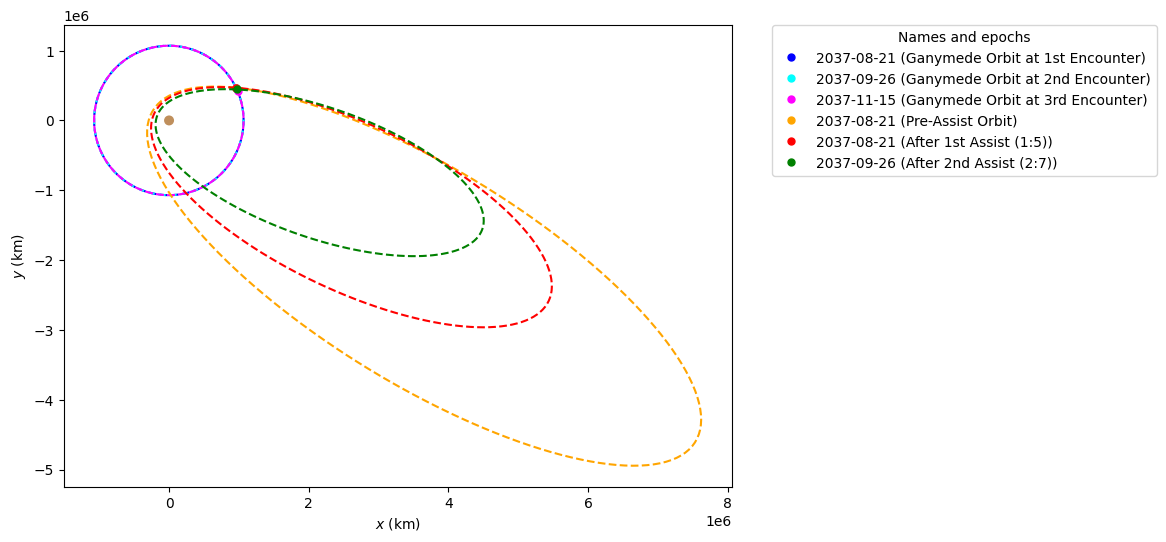

In [141]:
initial_orbit = post_insertion_orb

# Test the resonant slingshot function
r_p_min_test = 10 * u.km
r_p_max_test = 5000 * u.km

# First Ganymede encounter
print("=" * 60)
print("FIRST GANYMEDE ENCOUNTER")
print("=" * 60)
test_orbit_1, test_resonance_1, test_rp_1 = search_for_resonant_slingshot(
    ganymede_orb, 
    Ganymede, 
    initial_orbit.rv()[1], 
    r_p_min_test, 
    r_p_max_test,
    num_samples=500
)

if test_orbit_1 is not None:
    required_resonance_time=(test_resonance_1[1]/test_resonance_1[0])*ganymede_orb.period
    dif=test_orbit_1.period-required_resonance_time
    
    print(f"\n=== First Encounter Results ===")
    print(f"Resonance found: {test_resonance_1[0]}:{test_resonance_1[1]}")
    print(f"Spacecraft does {test_resonance_1[0]} orbits while Ganymede does {test_resonance_1[1]}")
    print(f"Post-assist orbit period: {test_orbit_1.period.to(u.day):.2f}, it should be close to {required_resonance_time.to(u.day):.2f}")
    print(f"Ganymede period: {ganymede_orb.period.to(u.day):.2f}")
    print(f"Flyby periapsis altitude: {(test_rp_1 - Ganymede.R).to(u.km):.0f}")
    print(f"Eccentricity: {test_orbit_1.ecc:.3f}")
    norm_vel_vec=(test_orbit_1.rv()[1]/np.linalg.norm(test_orbit_1.rv()[1]))
    total_dv=0*u.km/u.s
    dv_ajust=0.001*u.km/u.s
    if dif <0:
        #need to accelerate
        orbit_is_accurate=False
        while not orbit_is_accurate:
            total_dv+=dv_ajust
            delta_v=dv_ajust
            burn = delta_v*norm_vel_vec
            maneuver=Maneuver((0*u.s,burn))
            test_orbit_1=test_orbit_1.apply_maneuver(maneuver)
            dif=test_orbit_1.period-required_resonance_time
            if dif>=0:
                orbit_is_accurate=True
    if dif>0:
        #need to decelerate
        orbit_is_accurate=False
        while not orbit_is_accurate:
            total_dv+=dv_ajust
            delta_v=dv_ajust
            burn = -delta_v*norm_vel_vec
            print(burn)
            maneuver=Maneuver((0*u.s,burn))
            test_orbit_1=test_orbit_1.apply_maneuver(maneuver)
            dif=test_orbit_1.period-required_resonance_time
            if dif<=0:
                orbit_is_accurate=True            
    print(f"Total delta-v to adjust orbit: {total_dv.to(u.m/u.s):.2f}")
    
    # Calculate time to next encounter
    time_to_return_1 = test_resonance_1[0] * test_orbit_1.period
    print(f"\nTime until next Ganymede encounter: {time_to_return_1.to(u.day):.2f}")
    
    
    # Second Ganymede encounter
    print("\n" + "=" * 60)
    print("SECOND GANYMEDE ENCOUNTER")
    print("=" * 60)
    
    second_encounter_date = first_assist_date + time_to_return_1
    ganymede_orb_2 = placeholder_ganymede_orbit.propagate(second_encounter_date)
    
    test_orbit_2, test_resonance_2, test_rp_2 = search_for_resonant_slingshot(
        ganymede_orb_2, 
        Ganymede, 
        test_orbit_1.propagate(time_to_return_1).rv()[1], 
        r_p_min_test, 
        r_p_max_test,
        num_samples=500
    )
    
    if test_orbit_2 is not None:
        required_resonance_time_2=(test_resonance_2[1]/test_resonance_2[0])*ganymede_orb_2.period
        dif_2=test_orbit_2.period-required_resonance_time_2
        
        print(f"\n=== Second Encounter Results ===")
        print(f"Resonance found: {test_resonance_2[0]}:{test_resonance_2[1]}")
        print(f"Spacecraft does {test_resonance_2[0]} orbits while Ganymede does {test_resonance_2[1]}")
        print(f"Post-assist orbit period: {test_orbit_2.period.to(u.day):.2f}, it should be close to {required_resonance_time_2.to(u.day):.2f}")
        print(f"Flyby periapsis altitude: {(test_rp_2 - Ganymede.R).to(u.km):.0f}")
        print(f"Eccentricity: {test_orbit_2.ecc:.3f}")
        norm_vel_vec_2=(test_orbit_2.rv()[1]/np.linalg.norm(test_orbit_2.rv()[1]))
        total_dv_2=0*u.km/u.s
        dv_ajust_2=0.001*u.km/u.s
        if dif_2 <0:
            #need to accelerate
            orbit_is_accurate=False
            while not orbit_is_accurate:
                total_dv_2+=dv_ajust_2
                delta_v=dv_ajust_2
                burn = delta_v*norm_vel_vec_2
                maneuver=Maneuver((0*u.s,burn))
                test_orbit_2=test_orbit_2.apply_maneuver(maneuver)
                dif_2=test_orbit_2.period-required_resonance_time_2
                if dif_2>=0:
                    orbit_is_accurate=True
        if dif_2>0:
            #need to decelerate
            orbit_is_accurate=False
            while not orbit_is_accurate:
                total_dv_2+=dv_ajust_2
                delta_v=dv_ajust_2
                burn = -delta_v*norm_vel_vec_2
                maneuver=Maneuver((0*u.s,burn))
                test_orbit_2=test_orbit_2.apply_maneuver(maneuver)
                dif_2=test_orbit_2.period-required_resonance_time_2
                if dif_2<=0:
                    orbit_is_accurate=True            
        print(f"Total delta-v to adjust orbit: {total_dv_2.to(u.m/u.s):.2f}")
        
        time_to_return_2 = test_resonance_2[0] * test_orbit_2.period
        print(f"\nTime until third Ganymede encounter: {time_to_return_2.to(u.day):.2f}")
        ganymede_orb_3= placeholder_ganymede_orbit.propagate(second_encounter_date + time_to_return_2)
        
        
        # Visualize both orbits
        plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
        plotter.plot(ganymede_orb, label="Ganymede Orbit at 1st Encounter", color="blue")
        plotter.plot(ganymede_orb_2, label="Ganymede Orbit at 2nd Encounter", color="cyan")
        plotter.plot(ganymede_orb_3, label="Ganymede Orbit at 3rd Encounter", color="magenta")
        plotter.plot(initial_orbit, label="Pre-Assist Orbit", color="orange")
        plotter.plot(test_orbit_1, label=f"After 1st Assist ({test_resonance_1[0]}:{test_resonance_1[1]})", color="red")
        plotter.plot(test_orbit_2, label=f"After 2nd Assist ({test_resonance_2[0]}:{test_resonance_2[1]})", color="green")
        
        print(f"\n=== Mission Summary ===")
        print(f"Total ΔV for resonance corrections: {(total_dv + total_dv_2).to(u.m/u.s):.2f}")
        print(f"Total time: {(time_to_return_1 + time_to_return_2).to(u.day):.2f}")
        print(f"First encounter date: {first_assist_date}")
        print(f"Second encounter date: {second_encounter_date}")
        print(f"Third encounter date: {second_encounter_date + time_to_return_2}")
    else:
        print("No resonant orbit found for second encounter")
else:
    print("No resonant orbit found for first encounter - try adjusting periapsis bounds or tolerance")

In [121]:

# def find_assist_periapsis_bounds(dep_num,sling_bod_orb,inc_orb_vel,date):
#     sling_body=planet_order[dep_num]
#     target_body = planet_order[dep_num+1]

#     #relative velocity & speed to body we are slingshotting around
#     rel_vel = inc_orb_vel-sling_bod_orb.rv()[1]
#     rel_sped = np.linalg.norm(rel_vel)
    
#     r_ps = sling_body.R+np.geomspace(r_p_min,r_p_max,num=int(assist_transit_resolution/2))
#     rot_angs=2*np.arcsin(1/((r_ps*rel_sped*rel_sped/sling_body.k)+1*u.one))
#     #Now check if these (in plane) rotations lead to an orbit that reaches the target body
#     target_body_debug_orbit = Orbit.from_ephem(Jupiter,ephem_order[dep_num+1],date)
    
#     axis = np.array([0,0,1.0])   #rotate in ecliptic plane intitially
#     min_dv=1000000*u.km/u.s
#     target_arrival_date=None
#     flyby_rp=None
#     print(r_ps[17])

#     for sign in [-1]:
#         for i in range(len(rot_angs)):
#         # i=0
#             rot = scipyRot.from_rotvec(sign*axis*rot_angs[i])
#             rel_vel_out= rot.apply(1*rel_vel.value) * u.km/u.s
#             test_orb = Orbit.from_vectors(Jupiter,sling_bod_orb.r,rel_vel_out+sling_bod_orb.rv()[1],date,plane=Planes.EARTH_ECLIPTIC)
#             #check if apogee of new orbit reaches target, or is hyperbolic
#             #Note, does not work for gravity assists to bodies in lower orbits,
#             #Thus will need changes for Jovian grand tour
#             if (test_orb.r_p.value<target_body_debug_orbit.r_p.value and test_orb.ecc <1):
#                 #find time to reach target
#                 time_to_next=test_orb.t_a_fut
#                 reached_next_bod=False
#                 test_orb_prop=test_orb.propagate(time_to_next)
#                 # print(test_orb_prop.nu)
#                 while not reached_next_bod:
#                     # print(time_to_next.to(u.day))
#                     test_orb_prop=test_orb_prop.propagate(0.1*u.day)
#                     time_to_next += 0.1*u.day
#                     if np.linalg.norm(test_orb_prop.rv()[0]) < target_body_debug_orbit.a:
#                         reached_next_bod=True
#                 rough_arrival_date = date+time_to_next
#                 print(f"Arrival at {target_body} at roughly {rough_arrival_date}")
#                 target_arrival_orb = Orbit.from_ephem(Jupiter,ephem_order[dep_num+1],rough_arrival_date)   
#                 #Now evaluate lambert to target body
#                 man_lambert = Maneuver.lambert(sling_bod_orb, target_arrival_orb)
#                 lambert_test_orb=sling_bod_orb.apply_maneuver(man_lambert,intermediate=True)[0]
#                 # print(lambert_test_orb.r)
#                 # print(sling_bod_orb.r)
#                 # print(test_orb.r)
#                 speed_dif=abs(np.linalg.norm((lambert_test_orb.rv()[1]-sling_bod_orb.rv()[1])) - np.linalg.norm((test_orb.rv()[1]-sling_bod_orb.rv()[1])))
#                 if speed_dif < min_dv:
#                     # print(min_dv.to(u.km/u.s))
#                     min_dv=speed_dif
#                     target_arrival_date=deepcopy(rough_arrival_date)
#                     flyby_rp=sign*r_ps[i]

#             # print(f"It takes {min_dv} to reach {target_body.name} arriving at {target_arrival_date}")
#             # print(f"Trying to arrive at {target_body.name} on {target_arrival_date} leaving on {date}")
#     target_arrival_orb = Orbit.from_ephem(Jupiter, ephem_order[dep_num + 1], target_arrival_date)
#     man_lambert = Maneuver.lambert(sling_bod_orb, target_arrival_orb)
#     outgoing_orb = sling_bod_orb.apply_maneuver(man_lambert, intermediate=True)[0]       

#     # plotter.plot(test_orb, label="Test Orbit Propagation")
#     # plotter.plot(target_arrival_orb, label=f"{target_body.name} Orbit")
#     # plotter.plot(outgoing_orb, label=f"Post-Assist Orbit")
#     # plotter.plot(sling_bod_orb, label=f"{sling_body.name} Orbit")
#     return min_dv, target_arrival_date, outgoing_orb#, flyby_rp

In [122]:
planet_order=[Ganymede,Ganymede,Ganymede]
ephem_order=[ganymede_ephem,ganymede_ephem,ganymede_ephem]


r_p_min=10*u.km
r_p_max=8000*u.km
assist_transit_resolution=150

initial_orbit=deepcopy(post_insertion_orb)
initial_orbit=initial_orbit.propagate(tof_final)
initial_assist_date=arrival_date_final+tof_final
print(initial_orbit)

271483 x 8831671 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-10-22 20:05:53.879 (UTC)


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



In [123]:

#initial_orbit
dv_maneuvers_total=0
starship_orbits=[]
moon_orbits=[]



dv_maneuvers_total,arrive_bod_2_date, orb_after_1=find_assist_periapsis_bounds(0,ganymede_orb,initial_orbit.rv()[1],initial_assist_date)
if(dv_maneuvers_total<100*u.m/u.s):
    print(f"Viable assist at {initial_assist_date} with {planet_order[0]} to {planet_order[1]} arrving at {arrive_bod_2_date}.")
    bod_2_arriv_orb=orb_after_1.propagate(arrive_bod_2_date)
    bod_2_orb=Orbit.from_ephem(Jupiter, ephem_order[1], arrive_bod_2_date)
    moon_orbits.append(bod_2_orb)
    starship_orbits.append(bod_2_arriv_orb)
    next_dv,arrive_bod_3_date,orb_after_2=find_assist_periapsis_bounds(1,bod_2_orb,bod_2_arriv_orb.rv()[1],arrive_bod_2_date)
    if(next_dv<100*u.m/u.s):
        print(f"Viable 2nd assist arriving at {planet_order[2]} on {arrive_bod_3_date} with {next_dv.to(u.m/u.s)} at {planet_order[2]} at {arrive_bod_2_date}")
        dv_maneuvers_total+=next_dv
        moon_orbits.append(Orbit.from_ephem(Jupiter, ephem_order[2], arrive_bod_3_date))
        starship_orbits.append(orb_after_2.propagate(arrive_bod_3_date))
    else:
        print("No viable 2nd assist found.")

print(f"Total DV for assists: {dv_maneuvers_total.to(u.m/u.s)}")




NameError: name 'find_assist_periapsis_bounds' is not defined

Period of starship orbit after assist 1: 42.53934251746993 d
Period of starship orbit after assist 2: 43.32640707708409 d


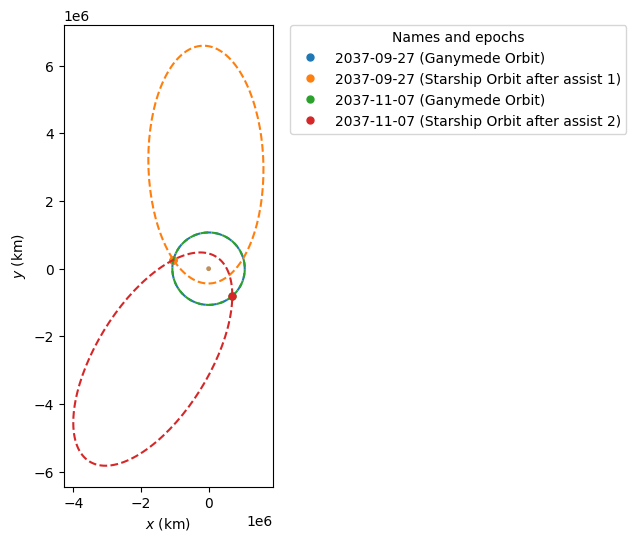

In [ ]:
# plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# for i in range(len(moon_orbits)):
#     plotter.plot(moon_orbits[i], label=f"{planet_order[i+1].name} Orbit")
#     plotter.plot(starship_orbits[i], label=f"Starship Orbit after assist {i+1}")
#     print(f"Period of starship orbit after assist {i+1}: {starship_orbits[i].period.to(u.day)}")

In [ ]:
# test_dv,test_date,test_orb,test_rp=find_assist_periapsis_bounds(0,ganymede_orb,initial_orbit.rv()[1],arrival_date_final+tof_final)      

# plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# ganymede_orb_debug= Orbit.from_ephem(Jupiter,ganymede_ephem,test_date)
# plotter.plot(initial_orbit, label="Initial Orbit")
# plotter.plot(test_orb, label="Test Orbit Propagation")
# plotter.plot(ganymede_orb_debug, label=f"Ganymede Orbit")

# # print(test_date)
# print(test_dv.to(u.km/u.s))
# print(test_rp.to(u.km))

2680543.621611806 m
Arrival at Ganymede (●) at roughly 2037-12-07 22:08:09.219
Arrival at Ganymede (●) at roughly 2037-12-07 21:46:50.347


AssertionError: 